In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

import desolver as de
import desolver.backend as D

D.set_float_fmt('float64')

Using numpy backend


In [23]:
@de.rhs_prettifier(
    equ_repr="[vx, -𝛿*vx - α*x - β*x**3 + γ*cos(ω*t)]",
    md_repr=r"""
$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$
"""
)
def rhs(t, state, delta, alpha, beta, gamma, omega, **kwargs):
    x,vx = state
    return D.stack([
        vx,
        -delta*vx - alpha*x - beta*x**3 + gamma*D.cos(omega*t)
    ])

In [24]:
print(rhs)
display(rhs)

[vx, -𝛿*vx - α*x - β*x**3 + γ*cos(ω*t)]



$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$


In [25]:
y_init = D.array([1., 0.])

In [71]:
#Let's define the fixed constants

constants = dict(
    delta = 0.3,
    omega = 1.2,
    alpha = -1.0,
    beta  = 1.0
)

# The period of the system
T = 2*D.pi / constants['omega']

# Initial and Final integration times
t0 = 0.0
tf = 40 * T

In [72]:
a = de.OdeSystem(rhs, y0=y_init, dense_output=True, t=(t0, tf), dt=0.01, rtol=1e-12, atol=1e-12, constants={**constants})
a.method = "RK87"

In [73]:
gamma_values = [0.20, 0.28, 0.29, 0.37, 0.5, 0.80]
integration_results = []

for gamma in gamma_values:
    a.reset()
    a.constants['gamma'] = gamma

    if gamma == 0.5:
        a.tf = 80.*T
        eval_times = D.linspace(18.1, 78.2, 3000)*T
        integer_period_multiples = D.arange(19, 78)*T
    else:
        a.tf = 40.*T
        eval_times = D.linspace(18.1, 38.2, 1000)*T
        integer_period_multiples = D.arange(19, 38)*T

    a.integrate()
    integration_results.append(((eval_times, a.sol(eval_times)), a.sol(integer_period_multiples)))

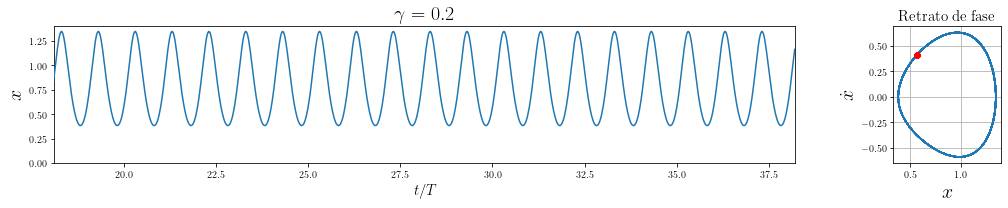

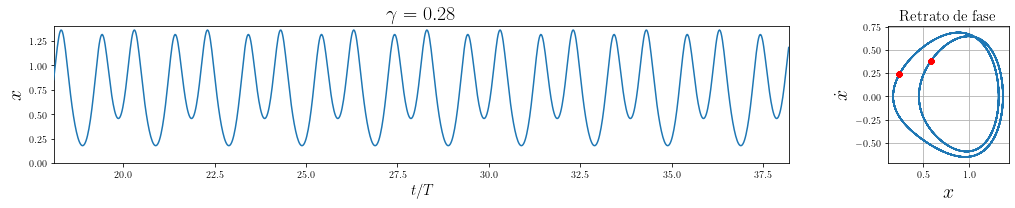

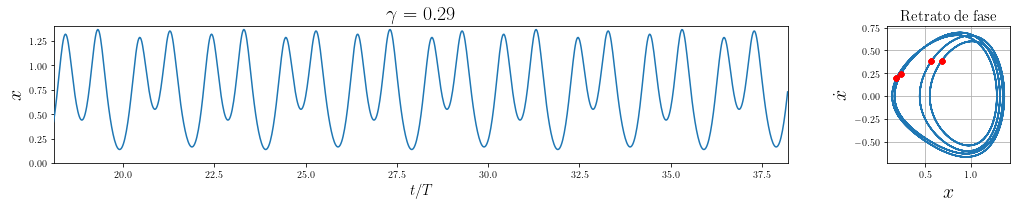

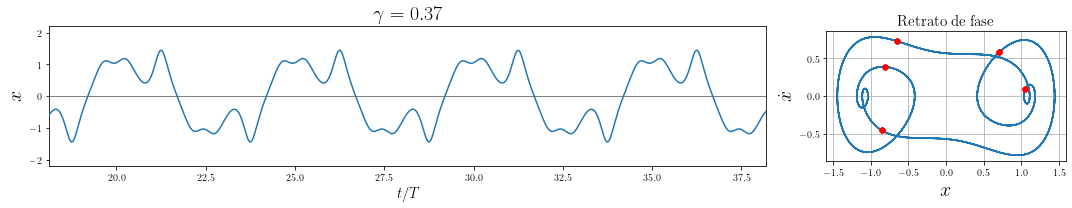

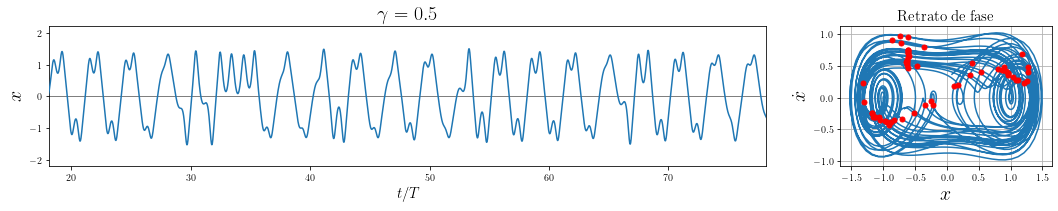

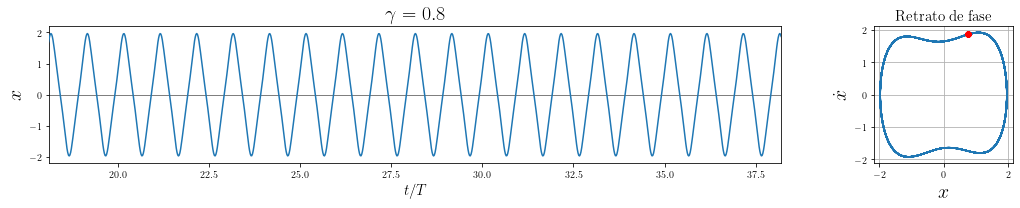

In [99]:
for gamma, ((state_times, states), period_states) in zip(gamma_values, integration_results):
    fig = plt.figure(figsize=(15, 3))

    gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax1.set_aspect(1)

    ax0.plot(state_times/T, states[:, 0], zorder=9)
    ax0.set_xlim(state_times[0]/T, state_times[-1]/T)
    if gamma < 0.37:
        ax0.set_ylim(0, 1.4)
    else:
        ax0.set_ylim(-2.2, 2.2)
        ax0.axhline(0, color='k', linewidth=0.5)
    ax0.set_xlabel('$t/T$', size=15)
    ax0.set_ylabel('$x$', size=20)
    ax0.set_title('$\gamma={}$'.format(gamma), size=20)

    ax1.plot(states[:, 0], states[:, 1])
    ax1.scatter(period_states[:, 0], period_states[:, 1], c='red', s=25, zorder=10)
    ax1.set_xlabel('$x$', size=20)
    ax1.set_ylabel('$\dot{x}$', size=20)
    ax1.grid(which='major')
    ax1.set_title('Retrato de fase', size=15)
    plt.tight_layout()